In [1]:
%load_ext nb_black

import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
import warnings

plt.style.use(style="seaborn")

%matplotlib inline

<IPython.core.display.Javascript object>

### Load Data

In [2]:
msft_df = pd.read_csv(
    "resources/HistoricalData_MSFT.csv", index_col="Date", parse_dates=True
)
msft_df.dropna()
msft_df.head(100)

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-05-24,$250.78,21411550,$247.785,$251.16,$247.51
2021-05-21,$245.17,21863060,$247.565,$248.33,$244.74
2021-05-20,$246.48,21800720,$243.96,$247.95,$243.86
2021-05-19,$243.12,25739810,$239.31,$243.23,$238.6
2021-05-18,$243.08,20167980,$246.27,$246.41,$242.9
...,...,...,...,...,...
2021-01-06,$212.25,35930650,$212.17,$216.4899,$211.94
2021-01-05,$217.9,23822950,$217.26,$218.52,$215.7
2021-01-04,$217.69,37130140,$222.53,$223,$214.81


<IPython.core.display.Javascript object>

### Data cleaning and slicing, sorting by ascending date.

In [3]:
df = msft_df[["Close/Last"]].copy()
df["Close/Last"] = df["Close/Last"].str.replace("$", "")
df["Close/Last"] = df["Close/Last"].astype("float")
df.sort_values("Date", ascending=True, inplace=True)
df

,Close/Last
Date,
2016-05-25,52.12
2016-05-26,51.89
2016-05-27,52.32
2016-05-31,53.00
2016-06-01,52.85
...,...
2021-05-18,243.08
2021-05-19,243.12
2021-05-20,246.48


<IPython.core.display.Javascript object>

In [4]:
df.describe(include="all")

,Close/Last
count,1258.000000
mean,125.053303
std,58.159735
min,48.430000
25%,73.592500
50%,108.210000
75%,164.907500
max,261.970000


<IPython.core.display.Javascript object>

### Stationarity
A stationary time series is one where the properties of the series do not depend on the time of the observation.  In other words, the summary statistics of the series do not depend on the time the series is observed, as is the case with series that show a trend or their mean varies over time or show seasonal effects.  To make a time series stationary means to remove trend and seasonal structures that negatively affect the regression model. 

 Here we use the adfuller() function to determine if our series is stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [5]:
# Check if the series of close prices is stationary (Mean Reverting)
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Close/Last"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.9627076722080757
p-value: 0.9938564633476441


<IPython.core.display.Javascript object>

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

### Differencing and the "i" term.

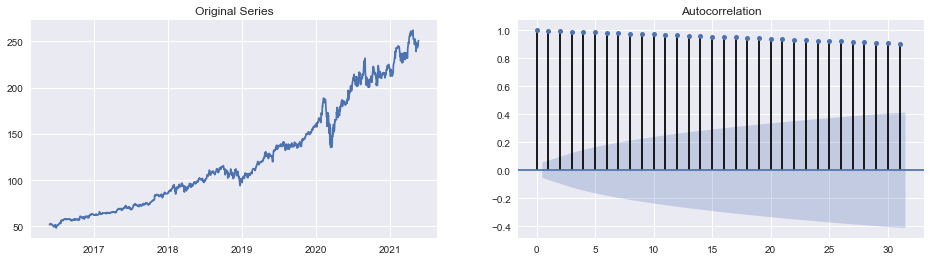

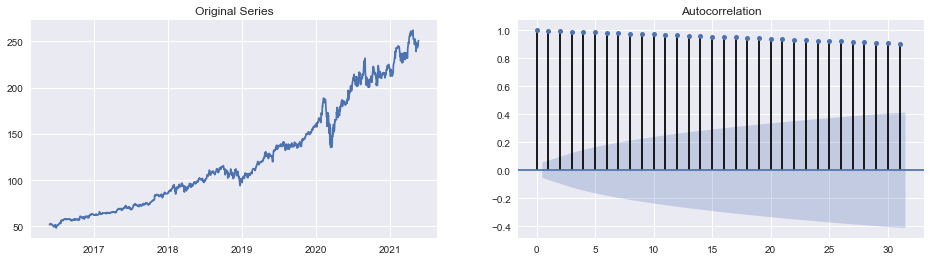

<IPython.core.display.Javascript object>

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df["Close/Last"])
ax1.set_title("Original Series")

plot_acf(df["Close/Last"], ax=ax2)

Note: The pair of charts is being repeated because of a bug in the plot_acf() function. 

All the ACF values are close to 1, this is indicative of a non-stationary sequence. Differencing is needed to make the sequence stationary.

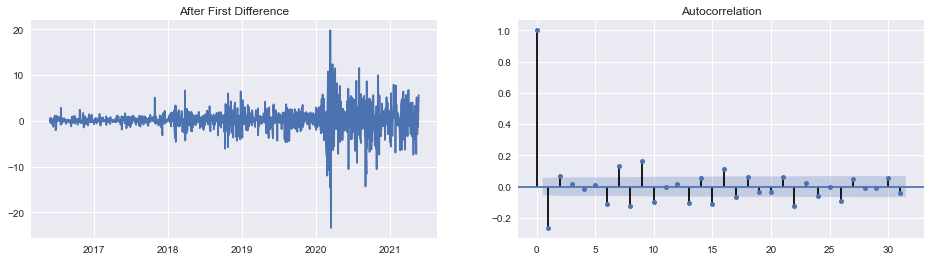

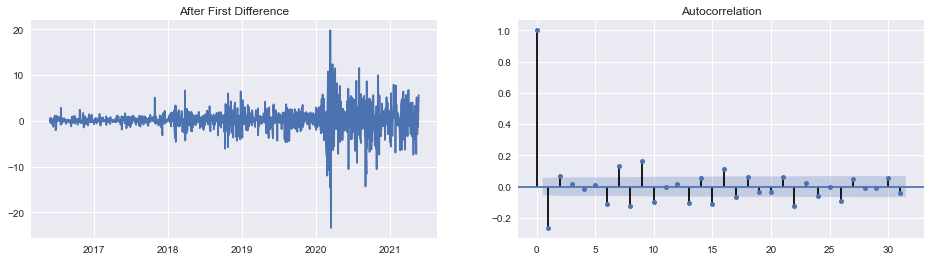

<IPython.core.display.Javascript object>

In [7]:
diff = df["Close/Last"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("After First Difference")

plot_acf(diff, ax=ax2)

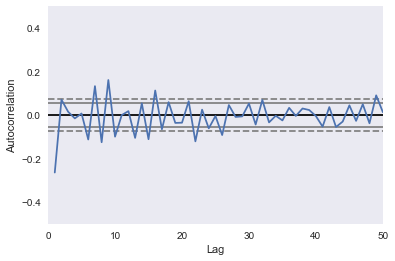

<IPython.core.display.Javascript object>

In [25]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(diff)
ax.set_xlim(0, 50)
ax.set_ylim(-0.5, 0.5)
plt.show()

After the first differencing, one can intuitively see that the sequence's mean value is stationary.

The correct value for the "i" term in the ARIMA(p,i,q) model is 1, since that is the number of times the series had to be differentiated to achieve stationarity.

Another way to get the correct value for the number of differences needed is by use of the ```pmdarima.ndiffs()``` function:

In [8]:
# pip install pmdarima

from pmdarima.arima.utils import ndiffs

ndiffs(df["Close/Last"], test="adf")

1

<IPython.core.display.Javascript object>

**p** and **q**

```p``` is the number of lags to be used as predictors and represents the order of the Auto Regressive term of the model equation (the "p" in ARIMA(p,i,q)).  The autocorrelation (plotted above) and partial autocorrelation (plotted below) 
functions are used for determining the "p" and "q" terms. 

The **q** term is the order of the **MA** term, or moving average term (the "q" in ARIMA(p,i,q) ) .



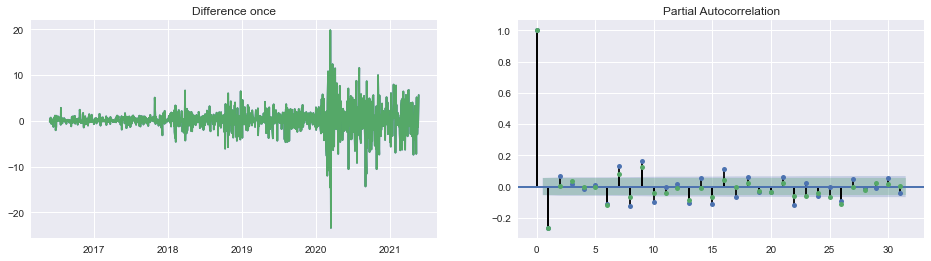

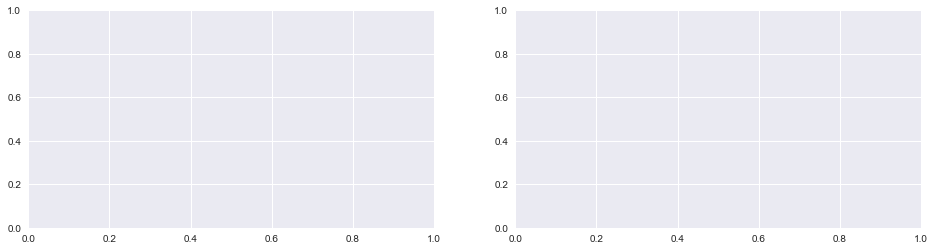

<IPython.core.display.Javascript object>

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = df["Close/Last"].diff().dropna()
fig, (x1, x2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
# ax2.set_ylim(0, 1)

plot_pacf(diff, ax=ax2)

(The second pair of plots in the bottom row is due to a bug in the plot_pacf() function.)

A more effective method is to let the values for **p**, **i**, and **q** be computed automatically via the ```auto_arima()``` function:

In [10]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(df["Close/Last"], trace=True, supress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5905.568, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5990.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5901.782, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5908.995, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5993.480, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5903.780, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5903.780, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5905.598, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5907.523, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.549 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2947.891
Date:                Thu, 03 Jun 2021   AIC                           5901.782
Time:                        20:28:00   BIC                           5917.191
Sample:                             0   HQIC                          5907.573
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1989      0.072      2.764      0.006       0.058       0.340
ar.L1         -0.2648      0.012    -22.699      0.000      -0.288      -0.242
sigma2         6.3752      0.114     56.126      0.000       6.153       6.598
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4380.55
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              32.26   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

We can see that the automatically computed values (1,1,0) produces the lowest Akaike's Information Criterion (AIC).

We now fit the ARIMA model:

In [11]:
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df["Close/Last"], order=(1, 1, 0))
result = model.fit(disp=0)
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Close/Last   No. Observations:                 1257
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2947.891
Method:                       css-mle   S.D. of innovations              2.525
Date:                Thu, 03 Jun 2021   AIC                           5901.782
Time:                        20:28:00   BIC                           5917.191
Sample:                             1   HQIC                          5907.573
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1572      0.056      2.791      0.005       0.047       0.268
ar.L1.D.Close/Last    -0.2648      0.027     -9.722      0.000      -0.318      -0.211
                    

<IPython.core.display.Javascript object>

### Residuals 

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

* The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

* The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-18.37387521, -14.96517291, -11.5564706 ,  -8.1477683 ,
         -4.73906599,  -1.33036369,   2.07833862,   5.48704092,
          8.89574322,  12.30444553,  15.71314783]),
 <a list of 1257 Lists of Patches objects>)

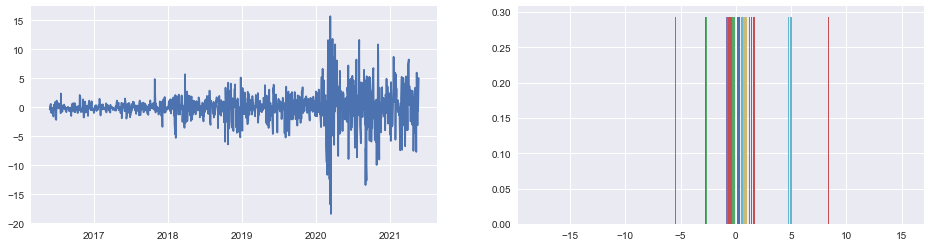

<IPython.core.display.Javascript object>

In [12]:
# Residuals

residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

Here we see the residuals' mean is around 0.

We not plot the first 60 days of the stock prices and the predicted values.  We can see the predicted values pretty much follow the actual values, which is a good indication that our model is a good fit.  But in this case the model is making predictions using the same training data.

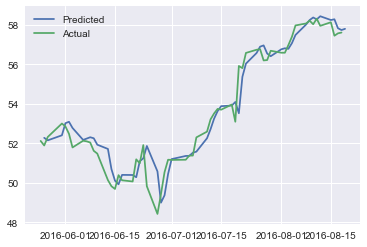

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots()
ax.plot(
    result.predict(start=1, end=60, dynamic=False, typ="levels"),
    label="Predicted",
)
ax.plot(df["Close/Last"].head(60), label="Actual")
leg = ax.legend()

### Test sets and predictions


Here we split the dataset into training and testing sets.
Training set goes from the first date in the original dataset until the record at the 80% mark.
Test set goes from 80% to the rest of the records.
For example, if there are 1258 records, the training set will include the first 1006, while the test set will include the remaining 252.

In [14]:
howmany = int(len(df) * 0.8)
tr_set = df["Close/Last"][:howmany]
ts_set = df["Close/Last"][howmany:]
print(len(ts_set))
print(len(tr_set))
print(len(df))
ts_set

252
1006
1258


Date
2020-05-26    181.57
2020-05-27    181.81
2020-05-28    181.40
2020-05-29    183.25
2020-06-01    182.83
               ...  
2021-05-18    243.08
2021-05-19    243.12
2021-05-20    246.48
2021-05-21    245.17
2021-05-24    250.78
Name: Close/Last, Length: 252, dtype: float64

<IPython.core.display.Javascript object>

In [15]:
tr_set

Date
2016-05-25     52.12
2016-05-26     51.89
2016-05-27     52.32
2016-05-31     53.00
2016-06-01     52.85
               ...  
2020-05-18    184.91
2020-05-19    183.63
2020-05-20    185.66
2020-05-21    183.43
2020-05-22    183.51
Name: Close/Last, Length: 1006, dtype: float64

<IPython.core.display.Javascript object>

We now fit the model to our training set.

In [16]:
model = ARIMA(tr_set, order=(1, 1, 0))
result = model.fit(disp=0)
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Close/Last   No. Observations:                 1005
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2156.064
Method:                       css-mle   S.D. of innovations              2.067
Date:                Thu, 03 Jun 2021   AIC                           4318.128
Time:                        20:28:16   BIC                           4332.866
Sample:                             1   HQIC                          4323.728
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1308      0.048      2.730      0.006       0.037       0.225
ar.L1.D.Close/Last    -0.3609      0.029    -12.278      0.000      -0.419      -0.303
                    

<IPython.core.display.Javascript object>

And here we forecast the next 30 days of closing prices, starting with the first date of the test set.

In [17]:
step = 30

fc, se, conf = result.forecast(step)

print(fc)  # 30 day forecasts
print(se)  # Standard errors
print(conf)  # Confidence levels

[183.6591957  183.78341764 183.91665299 184.04663526 184.17779162
 184.30852423 184.43940977 184.57024012 184.7010904  184.83193348
 184.96277915 185.09362389 185.22446897 185.35531393 185.48615893
 185.61700391 185.7478489  185.87869389 186.00953888 186.14038387
 186.27122886 186.40207384 186.53291883 186.66376382 186.79460881
 186.9254538  187.05629879 187.18714378 187.31798876 187.44883375]
[2.06747784 2.45362665 2.92408993 3.28337667 3.62171654 3.92613746
 4.21024394 4.47579496 4.72664102 4.96476359 5.19199915 5.40969018
 5.61895642 5.82070301 6.0156878  6.20454789 6.3878267  6.56599155
 6.73944807 6.9085509  7.07361228 7.23490884 7.39268701 7.54716744
 7.69854867 7.84701006 7.99271431 8.13580956 8.27643114 8.41470307]
[[179.6070136  187.71137779]
 [178.97439779 188.5924375 ]
 [178.18554203 189.64776394]
 [177.61133525 190.48193527]
 [177.07935764 191.27622559]
 [176.61343621 192.00361224]
 [176.18748329 192.69133626]
 [175.7978432  193.34263705]
 [175.43704422 193.96513657]
 [175.

<IPython.core.display.Javascript object>

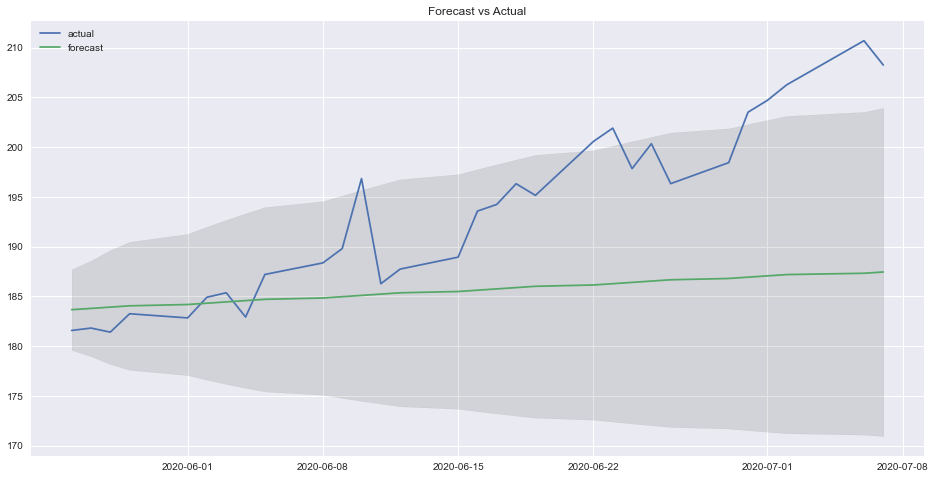

<IPython.core.display.Javascript object>

In [18]:
fc = pd.Series(fc, index=ts_set[:step].index)

lower = pd.Series(conf[:, 0], index=ts_set[:step].index)
upper = pd.Series(conf[:, 1], index=ts_set[:step].index)

plt.figure(figsize=(16, 8))
plt.plot(ts_set[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

The model was able to predict correct values up to about a week in the future.  After that, predictions are not as precise, even leaving the confidence area during the second week.
This demonstrates that this time-series algoritm cannot be used for long-term forcasting of stock prices. 
In general, there are many factors that go into determining a stock's price, and time-series anaylsis is not suitable to make these predictions, but the algorithm serves to give an idea of the trend followed by the stock price.